# Summary

This is an age image multiclass classification project that is predicting the age of a person based on their picture in three classes(young, middle, and old age). My stakeholder is the social media company Tik Tok who is having issues with consumers, especially children, lying about their age on the app. Having children lie about their age on the app can lead to children being fed content that is not appropriate for their age. I got my data from Kaggle which had over 23,000 images, but I lowered the amount in my project with over 3,000 images. I started out with my train, validation, test split by using the os to split the images. After I split the data  with the three classes in each of the split folders, I looked for any class imbalance in the dataset, but the classes were balanced. For preprocessing I cropped the images for face detection so that there will be less noise, put in data augmentation to add more data, and put in preprocessing for VGG19 and ResNet50. I tried to put in edge detection and sharpen the blurry images, but the edge detection took out important details in my images and I was not able to sharpen the blurry images that much. I mainly made three models which were CNN, VGG19, and ResNet50 models. My best model was my VGG19 model which gave an accuracy score of 78% for my test which had simple network with one dense layer with dropout and regularization. For my recommendations, I would say to use this model in the verification process of getting a user's age and the model may have issues predicting blurry images. My goal was to get an accuracy score of 70% or higher which was accomplished. For my next steps I want to try sharpening the images, try using different types of layers, try to predict for 10 classes with each class being in an age range of 10 years, and I want to try improving my accuracy.

# Business Understanding

The social media company Tik Tok has an issue with children getting inappropriate content and advertisements for their age because some children lie about their age to not be limited. Parents and governments are concerned about this because parents have no control over what their kid sees and governments want their children to be safe. Tik Tok needs an image classifier to look at profile photos or posts to predict what age the person actually is.

# Data Understanding



* 23,000+ images from Kaggle
* Predicting age
* Creating 3 classes:
  - Young age(1 year old to 29 year old)
  - Middle age(30 years old to 59 years old)
  - Old age (60+ years old)





In [25]:
# Importing all packages
import shutil
import cv2
from google.colab.patches import cv2_imshow
import os
import sys
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications import VGG19
from keras.applications import ResNet50
from keras.optimizers import Adam
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Activation, Input, LSTM, Reshape, TimeDistributed, GlobalAveragePooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings("ignore")

from keras import layers
from keras import models
from keras import optimizers

from sklearn.utils.class_weight import compute_class_weight
import joblib
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import random

In [26]:
# Connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Understanding


* Got my data from Kaggle and started out with 23,000+ images with varying ages
* My target, age, has three class, young age(1-29 year olds), middle age(30-59 year olds), and old age(60+ years old)



In [27]:
# Open the pickle file in binary mode
with open("/content/drive/MyDrive/Colab_Notebooks/Age.pkl", "rb") as f:
    # Load the contents of the file using the pickle.load() function
    df = pickle.load(f)
df

,filename,age
0,young_22_0_0_20170104214301269.jpg,young_age
1,young_28_0_3_20170104215712759.jpg,young_age
2,young_28_0_3_20170104220743173.jpg,young_age
3,young_27_1_3_20170104223405095.jpg,young_age
4,young_10_1_3_20170104221633430.jpg,young_age
...,...,...
4026,old_65_0_0_20170111195233409.jpg,old_age
4027,old_65_0_0_20170111195430569.jpg,old_age
4028,old_72_0_0_20170111195358992.jpg,old_age
4029,old_65_0_0_20170111195412945.jpg,old_age


##### Looked at my classes to make sure there was no class imbalance which there were not

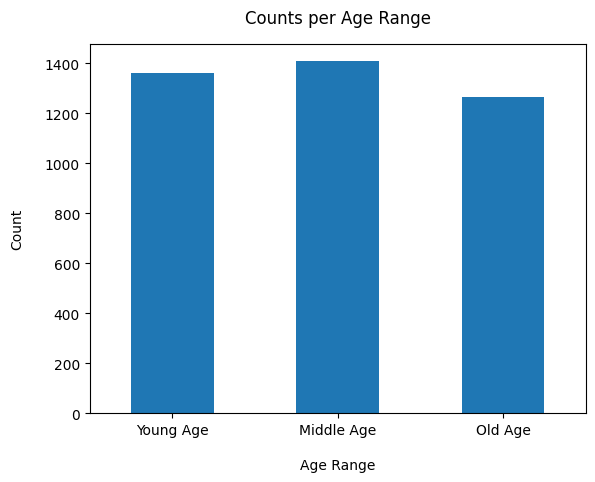

In [28]:
# Looking at the distribution of pictures for each class subfolder
# The classes seem balanced
category_counts = df['age'].value_counts()
category_counts = category_counts.reindex(['young_age', 'middle_age', 'old_age'])
category_counts.plot.bar()
labels = ['Young Age', 'Middle Age', 'Old Age']
plt.gca().set_xticklabels(labels, rotation=0)
plt.xlabel('Age Range', labelpad=15)
plt.ylabel('Count', labelpad=15)
plt.title('Counts per Age Range', pad=15);

# Data Preparation

For my data preparation I started out with: 

* Face detection by cropping out the face to get only the face and some hair
* Edge detection to get important information such as wrinkles
* There were may images that needed sharpening because they were blurry and the edge detection was doing well on the blurry images
* I did data augmentation to add on extra data for the models to train on
* VGG19 and ResNet50 transfer learning to add preprocessing specific to the VGG19 and ResNet50 models



#### Making separate face detection files to take out noise from the images

In [29]:
# Creating directories for the train, test, and validation folders
train_dir = '/content/drive/MyDrive/Colab_Notebooks/Images/Train'
test_dir = '/content/drive/MyDrive/Colab_Notebooks/Images/Test'
val_dir = '/content/drive/MyDrive/Colab_Notebooks/Images/Val'

In [ ]:
# Got pretrained face detection from an OpenCV from GitHub
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Colab_Notebooks/Pretrained/face/haarcascade_frontalface_default.xml')

# Created a train directory for the new face detections to go to
output_dir_faces = '/content/drive/MyDrive/Colab_Notebooks/Pretrained/face'

# Making the new file path for the cropped images if they have jpg at the end of the file name
for dirpath, dirnames, filenames in os.walk(train_dir):
  for filename in filenames:
    if filename.endswith('.jpg'):
      img_path = os.path.join(dirpath, filename)
      img = cv2.imread(img_path)
# Change image to gray color
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Applying the face cascade to the input image(s)
# The scale factor controls how much the image is reduced at each image scale and the minNeighbors specifies how many neighbors each reactangle should have to be considered a face
      faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
# Looping through each detected face rectangle and detecting the width and height which then gets a unique file name
      for i, (x,y,w,h) in enumerate(faces):
        face = img[y:y+h, x:x+w]
        output_path_face = os.path.join(output_dir_faces, f'{filename}_face_{i}.jpg')
        cv2.imwrite(output_path_face, face)
cv2.destroyAllWindows()

In [ ]:
# Doing the same thing but for the validation
output_dir_faces_val = '/content/drive/MyDrive/Colab_Notebooks/Pretrained/Val/Face'

for dirvalpath, dirvalnames, valfilenames in os.walk(val_dir):
  for valfilename in valfilenames:
    if valfilename.endswith('.jpg'):
      img_path_val = os.path.join(dirvalpath, valfilename)
      img_val = cv2.imread(img_path_val)

      gray_val = cv2.cvtColor(img_val, cv2.COLOR_BGR2GRAY)

      faces_val = face_cascade.detectMultiScale(gray_val, scaleFactor=1.3, minNeighbors=5)

      for i, (x,y,w,h) in enumerate(faces_val):
        face_val = img_val[y:y+h, x:x+w]
        output_path_face_val = os.path.join(output_dir_faces_val, f'{valfilename}_face_{i}.jpg')
        cv2.imwrite(output_path_face_val, face_val)
cv2.destroyAllWindows()

In [ ]:
# Doing the same thing but for the test
output_dir_faces_test = '/content/drive/MyDrive/Colab_Notebooks/Pretrained/Test/Face'

for dirtestpath, dirtestnames, testfilenames in os.walk(test_dir):
  for testfilename in testfilenames:
    if testfilename.endswith('.jpg'):
      img_path_test = os.path.join(dirtestpath, testfilename)
      img_test = cv2.imread(img_path_test)

      gray_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)

      faces_test = face_cascade.detectMultiScale(gray_test, scaleFactor=1.3, minNeighbors=5)

      for i, (x,y,w,h) in enumerate(faces_test):
        face_test = img_test[y:y+h, x:x+w]
        output_path_face_test = os.path.join(output_dir_faces_test, f'{testfilename}_face_{i}.jpg')
        cv2.imwrite(output_path_face_test, face_test)
cv2.destroyAllWindows()

In [ ]:
# Extracting the age from the file name by splitting the '_' and getting the first string
def extract_age(filename):
    age_str = filename.split('_')[1]  # assuming the age is the first part of the filename
    return int(age_str)

In [ ]:
# Splitting up the files within the train, validation, and test files to create subfolders for the three 3 age classes
# This is for the train file
for dirpath, dirnames, filenames in os.walk('/content/drive/MyDrive/Colab_Notebooks/Pretrained/face'):
    for filename in filenames:
        if filename.endswith('.jpg'):
            age = extract_age(filename)
            if age < 30:
              class_name='young_age'
            elif age < 60:
              class_name = 'middle_age'
            else:
              class_name = 'old_age'
            class_dir = os.path.join('/content/drive/MyDrive/Colab_Notebooks/Pretrained/Train', class_name)
            os.makedirs(class_dir, exist_ok=True)
            src_path = os.path.join(dirpath, filename)
            dst_path = os.path.join(class_dir, filename)
            shutil.copy(src_path, dst_path)

In [ ]:
# Splitting up the files within the train, validation, and test files to create subfolders for the three 3 age classes
# This is for the validation file
for dirvalpath, dirvalnames, valfilenames in os.walk('/content/drive/MyDrive/Colab_Notebooks/Pretrained/Val/Face'):
    for valfilename in valfilenames:
        if valfilename.endswith('.jpg'):
            age_val = extract_age(valfilename)
            if age_val < 30:
              class_name_val='young_age'
            elif age_val < 60:
              class_name_val = 'middle_age'
            else:
              class_name_val = 'old_age'
            class_dir_val = os.path.join('/content/drive/MyDrive/Colab_Notebooks/Pretrained/Val', class_name_val)
            os.makedirs(class_dir_val, exist_ok=True)
            src_path_val = os.path.join(dirvalpath, valfilename)
            dst_path_val = os.path.join(class_dir_val, valfilename)
            shutil.copy(src_path_val, dst_path_val)

In [ ]:
# Splitting up the files within the train, validation, and test files to create subfolders for the three 3 age classes
# This is for the test file
for dirtestpath, dirtestnames, testfilenames in os.walk('/content/drive/MyDrive/Colab_Notebooks/Pretrained/Test/Face'):
    for testfilename in testfilenames:
        if testfilename.endswith('.jpg'):
            age_test = extract_age(testfilename)
            if age_test < 30:
              class_name_test='young_age'
            elif age_test < 60:
              class_name_test = 'middle_age'
            else:
              class_name_test = 'old_age'
            class_dir_test = os.path.join('/content/drive/MyDrive/Colab_Notebooks/Pretrained/Test', class_name_test)
            os.makedirs(class_dir_test, exist_ok=True)
            src_path_test = os.path.join(dirtestpath, testfilename)
            dst_path_test = os.path.join(class_dir_test, testfilename)
            shutil.copy(src_path_test, dst_path_test)

In [30]:
# Creating directories for the new train, validation, and test images with cropped face detected images from the original images
new_train_dir = '/content/drive/MyDrive/Colab_Notebooks/Pretrained/Train'
new_test_dir = '/content/drive/MyDrive/Colab_Notebooks/Pretrained/Test'
new_val_dir = '/content/drive/MyDrive/Colab_Notebooks/Pretrained/Val'

#### Getting the edges using Sobel to to get important information like wrinkles, but it ended up taking away important information for the model and it did not do well for blurry images

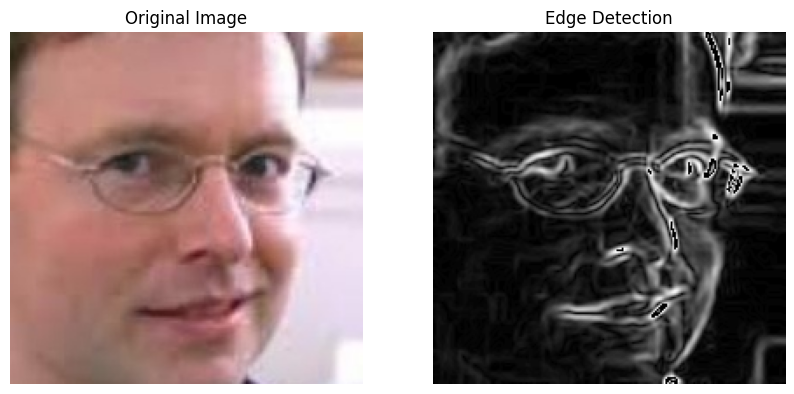

In [31]:
# Defining a function to detect edges in an image
def detect_edges(img):
  # Cheking if image has 3 channels and if it does have color then convert the image to a grayscale 
  if img.ndim == 3 and img.shape[-1] == 3:
    img = img * 255
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Applying Gaussian blur to reduce noise
  blurred = cv2.GaussianBlur(img, (5, 5), 0)

  # Applying Sobel filter to detect the edges and Sobel is more precise in detecting wrinkles on a person's face
  grad_x = cv2.Sobel(blurred, cv2.CV_16S, 1, 0, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
  grad_y = cv2.Sobel(blurred, cv2.CV_16S, 0, 1, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)

  # Calculating the edge strength and converting it to uint8
  edges = np.sqrt(grad_x**2 + grad_y**2)
  edges = np.uint8(edges)

  # Add an additional dimension to edges array and normalize the values between 0 and 1
  edges = np.expand_dims(edges, axis=-1)
  edges = edges / 255

  # Return the edges
  return edges

# Defining a function to plot the comparison between the original and edged images
def plot_edges(img):
  # Detect the edges in the image
  edges = detect_edges(img)

  # Creating a subplot to show the original and edged images side by side 
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))

  # Showing the original image
  ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  ax[0].set_title('Original Image')
  ax[0].axis('off')

  # Showing the edged image
  ax[1].imshow(edges, cmap='gray')
  ax[1].set_title('Edge Detection')
  ax[1].axis('off')

  # Displaying the image
  plt.show()

# Creating a path for the image and reading the image
img_path = '/content/drive/MyDrive/Colab_Notebooks/Pretrained/Test/middle_age/middle_30_0_0_20170104202024970.jpg_face_0.jpg'
img = cv2.imread(img_path)

# Plotting the original image and its edges
plot_edges(img)

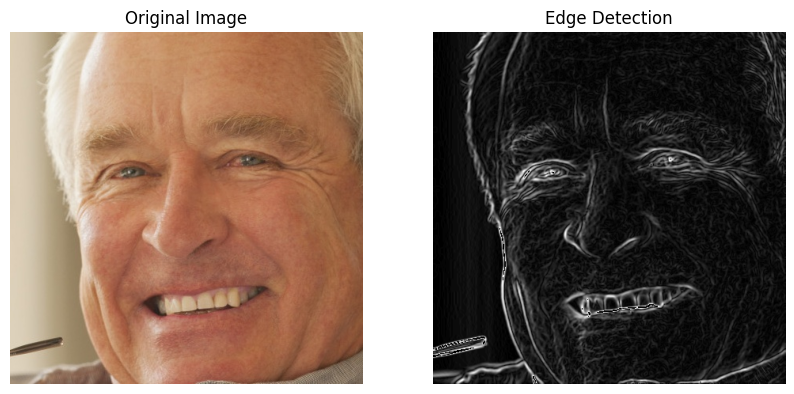

In [32]:
# Plotting another image for old age to see the wrinkles
img_path2 = '/content/drive/MyDrive/Colab_Notebooks/Pretrained/Test/old_age/old_65_0_0_20170111195233409.jpg_face_0.jpg'
img2 = cv2.imread(img_path2)
plot_edges(img2)

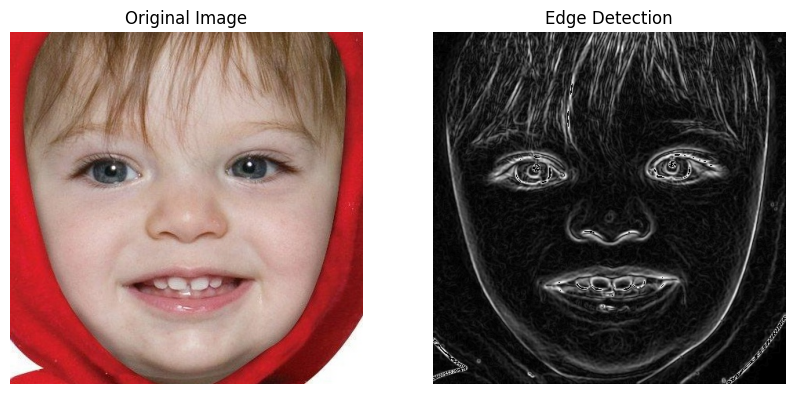

In [33]:
# Plotting another image for young age
img_path3 = '/content/drive/MyDrive/Colab_Notebooks/Pretrained/Test/young_age/young_2_0_0_20170109193935916.jpg_face_0.jpg'
img3 = cv2.imread(img_path3)
plot_edges(img3)

#### Thought of sharpening the blurry images using deconvolution to smooth out the pixels, but the sharpening ended up making the image look worse which led me to not use face detection and sharpening the images

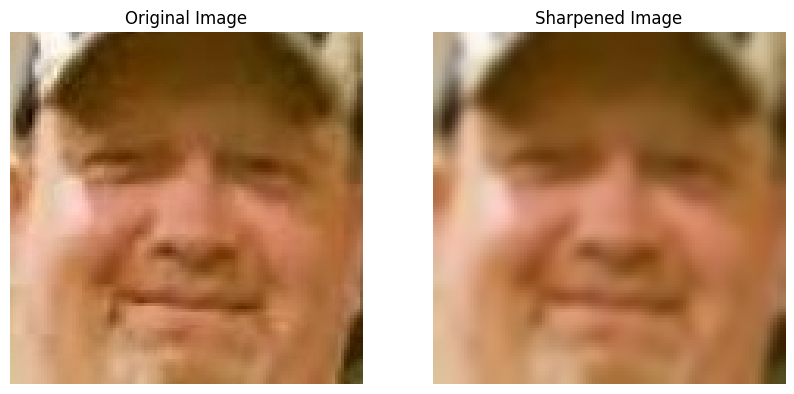

In [34]:
# Defining a 5x5 kernel with all elements set to 1 and divide by 25 
def deconvolution(img):
  kernel = np.ones((5, 5), np.float32)/25

  # Applying the filter/kernel to the input image using 2D convolution
  deconvolved = cv2.filter2D(img, -1, kernel)

  # Return the resulting image after convolution
  return deconvolved

# Defining a function to plot the comparison between the original image and the shaprened version
def plot_edges(img):

  # Performing deconvolution in the input image
  masking = deconvolution(img)

  # Creating a figure with 2 subplots
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))

  # Showing the original image in color
  ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  ax[0].set_title('Original Image')
  ax[0].axis('off')

  # Showing the smoothed out version of the original image
  ax[1].imshow(cv2.cvtColor(masking, cv2.COLOR_BGR2RGB))
  ax[1].set_title('Sharpened Image')
  ax[1].axis('off')

  # Displaying the image
  plt.show()

# Creating a path for the image and reading the image
img_path_sharp = '/content/drive/MyDrive/Colab_Notebooks/Pretrained/Train/middle_age/middle_30_0_0_20170103181149464.jpg_face_0.jpg'
img_sharp = cv2.imread(img_path_sharp)

# Plotting the original image and its sharpened version
plot_edges(img_sharp)

### Data Generators

#### Non preprocessed image generators for the base model to see how it will score

In [35]:
# Creating image data generators for the non cropped training, validation, and testing sets

# Rescaling the train data generator to create a singular size of the images for the model
base_train_datagen = ImageDataGenerator(rescale=1./255)

# Rescaling the image for the validation and test generators
base_val_datagen = ImageDataGenerator(rescale=1./255)

base_test_datagen = ImageDataGenerator(rescale=1./255)

# Connecting the directory to the generator for train, validation, and test
# Making the size of the image 256x256, the batch size 64, and class mode categorical since this is multiclass 
base_train_generator = base_train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical')

base_validation_generator = base_val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical')

base_test_generator = base_test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical')

Found 3268 images belonging to 3 classes.
Found 361 images belonging to 3 classes.
Found 402 images belonging to 3 classes.


In [36]:
# Printing the class indices, but the classes are out of order
print(base_train_generator.class_indices)
print(base_validation_generator.class_indices)
print(base_test_generator.class_indices)

{'middle_age': 0, 'old_age': 1, 'young_age': 2}
{'middle_age': 0, 'old_age': 1, 'young_age': 2}
{'middle_age': 0, 'old_age': 1, 'young_age': 2}


In [37]:
# Fixing the order of the class indices
new_class_indices = {'young_age': 0, 'middle_age': 1, 'old_age': 2}

base_train_generator.class_indices = new_class_indices
base_test_generator.class_indices = new_class_indices
base_validation_generator.class_indices = new_class_indices

print(base_train_generator.class_indices)
print(base_validation_generator.class_indices)
print(base_test_generator.class_indices)

{'young_age': 0, 'middle_age': 1, 'old_age': 2}
{'young_age': 0, 'middle_age': 1, 'old_age': 2}
{'young_age': 0, 'middle_age': 1, 'old_age': 2}


In [52]:
# Creating 2 variables and extracting the next images and labels by batches of 64 for the test
base_test_images, base_test_labels = next(base_test_generator)

#### Preprocessed Image generator for the rest of the CNN models

In [53]:
# Creating image data generators for training, validation, and testing sets

# Augmenting the train data generator to create more data to feed the model
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    brightness_range=[0.5, 2.5])

# Rescaling the image for the validation and test generators
val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Connecting the directory to the generator for train, validation, and test
# Making the size of the image 256x256, the batch size 64, and class mode categorical since this is multiclass 
train_generator = train_datagen.flow_from_directory(
    directory=new_train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    directory=new_val_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical')

# Shuffle is false to make sure that the test data is not randomized
test_generator = test_datagen.flow_from_directory(
    directory=new_test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',
    shuffle=False)

Found 2849 images belonging to 3 classes.
Found 302 images belonging to 3 classes.
Found 302 images belonging to 3 classes.


In [54]:
# Printing the class indices, but the classes are out of order
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'middle_age': 0, 'old_age': 1, 'young_age': 2}
{'middle_age': 0, 'old_age': 1, 'young_age': 2}
{'middle_age': 0, 'old_age': 1, 'young_age': 2}


In [55]:
# Fixing the order of the class indices
new_class_indices = {'young_age': 0, 'middle_age': 1, 'old_age': 2}

train_generator.class_indices = new_class_indices
test_generator.class_indices = new_class_indices
validation_generator.class_indices = new_class_indices

print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'young_age': 0, 'middle_age': 1, 'old_age': 2}
{'young_age': 0, 'middle_age': 1, 'old_age': 2}
{'young_age': 0, 'middle_age': 1, 'old_age': 2}


In [56]:
# Creating 2 variables and extracting the next images and labels by batches of 64 for the test
test_images, test_labels = next(test_generator)

### VGG19 Data Generator

In [57]:
# Creating image data generators for training, validation, and testing sets, but for vgg19 models

# Pretrained preprocessing specifically for vgg19 models to create better accuracy scores
# Did not use augmentation because it lowers my accuracy for the vgg19 models 
vgg19_train_datagen = ImageDataGenerator(rescale=1./255,
                                         preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

# Rescaling the image for the vgg19 validation and test generators
vgg19_val_datagen = ImageDataGenerator(rescale=1./255, 
                                       preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
vgg19_test_datagen = ImageDataGenerator(rescale=1./255, 
                                        preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

# Connecting the directory to the vgg19 generators for train, validation, and test
# Making the size of the image 256x256, the batch size 64, and class mode categorical since this is multiclass 
vgg19_train_generator = vgg19_train_datagen.flow_from_directory(
    directory=new_train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical')

vgg19_validation_generator = vgg19_val_datagen.flow_from_directory(
    directory=new_val_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical')

# Shuffle is false to make sure that the test data is not randomized
vgg19_test_generator = vgg19_test_datagen.flow_from_directory(
    directory=new_test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',
    shuffle=False)

Found 2849 images belonging to 3 classes.
Found 302 images belonging to 3 classes.
Found 302 images belonging to 3 classes.


In [58]:
# Printing the class indices, but the classes are out of order
print(vgg19_train_generator.class_indices)
print(vgg19_validation_generator.class_indices)
print(vgg19_test_generator.class_indices)

{'middle_age': 0, 'old_age': 1, 'young_age': 2}
{'middle_age': 0, 'old_age': 1, 'young_age': 2}
{'middle_age': 0, 'old_age': 1, 'young_age': 2}


In [59]:
# Fixing the order of the class indices
vgg19_train_generator.class_indices = new_class_indices
vgg19_test_generator.class_indices = new_class_indices
vgg19_validation_generator.class_indices = new_class_indices

print(vgg19_train_generator.class_indices)
print(vgg19_validation_generator.class_indices)
print(vgg19_test_generator.class_indices)

{'young_age': 0, 'middle_age': 1, 'old_age': 2}
{'young_age': 0, 'middle_age': 1, 'old_age': 2}
{'young_age': 0, 'middle_age': 1, 'old_age': 2}


In [60]:
# Creating 2 variables and extracting the next images and labels by batches of 64 for the test
vgg19_test_images, vgg19_test_labels = next(vgg19_test_generator)

### ResNet50 Data Generator

In [61]:
# Creating image data generators for training, validation, and testing sets, but for resnet50 models

# Pretrained preprocessing specifically for resnet50 models to create better accuracy scores
# Did not use augmentation because it lowers my accuracy for the resnet50 models 
resnet50_train_datagen = ImageDataGenerator(rescale=1./255,
                                            preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

# Rescaling the image for the resnet50 validation and test generators
resnet50_val_datagen = ImageDataGenerator(rescale=1./255, 
                                       preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
resnet50_test_datagen = ImageDataGenerator(rescale=1./255, 
                                        preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

# Connecting the directory to the resnet50 generators for train, validation, and test
# Making the size of the image 256x256, the batch size 64, and class mode categorical since this is multiclass 
resnet50_train_generator = resnet50_train_datagen.flow_from_directory(
    directory=new_train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical')

resnet50_validation_generator = resnet50_val_datagen.flow_from_directory(
    directory=new_val_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical')

# Shuffle is false to make sure that the test data is not randomized
resnet50_test_generator = resnet50_test_datagen.flow_from_directory(
    directory=new_test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical')

Found 2849 images belonging to 3 classes.
Found 302 images belonging to 3 classes.
Found 302 images belonging to 3 classes.


In [62]:
# Printing the class indices, but the classes are out of order
print(resnet50_train_generator.class_indices)
print(resnet50_validation_generator.class_indices)
print(resnet50_test_generator.class_indices)

{'middle_age': 0, 'old_age': 1, 'young_age': 2}
{'middle_age': 0, 'old_age': 1, 'young_age': 2}
{'middle_age': 0, 'old_age': 1, 'young_age': 2}


In [63]:
# Fixing the order of the class indices
resnet50_train_generator.class_indices = new_class_indices
resnet50_test_generator.class_indices = new_class_indices
resnet50_validation_generator.class_indices = new_class_indices

print(resnet50_train_generator.class_indices)
print(resnet50_validation_generator.class_indices)
print(resnet50_test_generator.class_indices)

{'young_age': 0, 'middle_age': 1, 'old_age': 2}
{'young_age': 0, 'middle_age': 1, 'old_age': 2}
{'young_age': 0, 'middle_age': 1, 'old_age': 2}


In [64]:
# Creating 2 variables and extracting the next images and labels by batches of 64 for the test
resnet50_test_images, resnet50_test_labels = next(resnet50_test_generator)

# Modeling

### Base Model

In [68]:
# Baseline model
# Defining the architecture of the model
model_base = models.Sequential()

model_base.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(256, 256, 3)))
model_base.add(layers.MaxPooling2D((2, 2)))

model_base.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_base.add(layers.MaxPooling2D((2, 2)))

model_base.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_base.add(layers.MaxPooling2D((2, 2)))

model_base.add(layers.Flatten())
model_base.add(layers.Dense(128, activation='relu'))
model_base.add(layers.Dense(3, activation='softmax'))

In [69]:
# Compiling the model and getting the summary
model_base.compile(loss='categorical_crossentropy',
              optimizer= 'adam',
              metrics=['acc'])
model_base.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 30, 128)     

In [70]:
# Creating early stopping by looking at the validation accuracy and stopping if the accuracy does not change by .01 for 5 epochs
early_stop = EarlyStopping(monitor='val_acc', min_delta=0.01, patience=5)
history = model_base.fit(base_train_generator,
                    steps_per_epoch=len(base_train_generator),
                    epochs= 50,
                    validation_data=base_validation_generator,
                    validation_steps=len(base_validation_generator),
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
52/52 [==============================] - 648s 12s/step - loss: 1.3633 - acc: 0.3446 - val_loss: 1.0738 - val_acc: 0.4238
Epoch 2/50
52/52 [==============================] - 41s 788ms/step - loss: 1.0074 - acc: 0.5147 - val_loss: 0.9672 - val_acc: 0.5568
Epoch 3/50
52/52 [==============================] - 41s 784ms/step - loss: 0.8909 - acc: 0.6013 - val_loss: 0.9024 - val_acc: 0.6011
Epoch 4/50
52/52 [==============================] - 39s 760ms/step - loss: 0.8002 - acc: 0.6521 - val_loss: 0.9107 - val_acc: 0.5789
Epoch 5/50
52/52 [==============================] - 40s 762ms/step - loss: 0.6875 - acc: 0.7096 - val_loss: 0.9455 - val_acc: 0.5928
Epoch 6/50
52/52 [==============================] - 38s 739ms/step - loss: 0.5546 - acc: 0.7684 - val_loss: 1.0878 - val_acc: 0.5789
Epoch 7/50
52/52 [==============================] - 39s 740ms/step - loss: 0.3641 - acc: 0.8638 - val_loss: 1.3016 - val_acc: 0.5762
Epoch 8/50
52/52 [==============================] - 40s 774ms/step - l

In [71]:
test_results_base = model_base.evaluate(base_test_images, base_test_labels)

2/2 [==============================] - 1s 26ms/step - loss: 2.4362 - acc: 0.4844


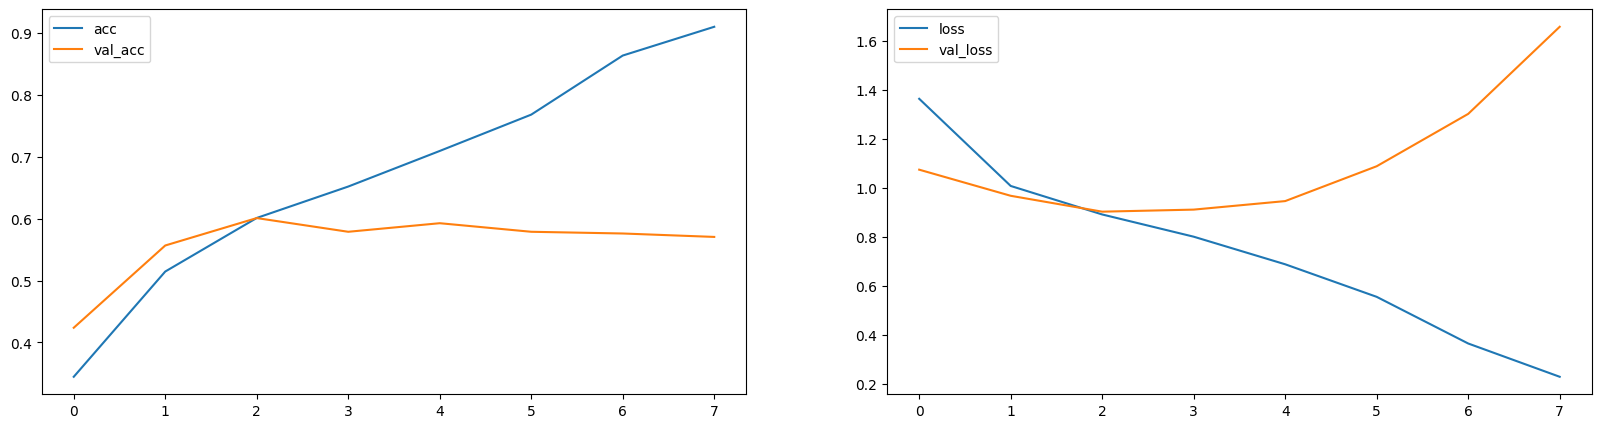

In [72]:
# Creating ROC Curve for the accuracy and the loss
acc_base = history.history['acc']
val_acc_base = history.history['val_acc']
loss_base = history.history['loss']
val_loss_base = history.history['val_loss']

# Plotting the training and validation accuracy on the first subplot
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.plot(acc_base, label='acc')
plt.plot(val_acc_base, label='val_acc')
plt.legend()

# Plotting the training and validation loss on the second subplot
plt.subplot(1, 2, 2)
plt.plot(loss_base, label= 'loss')
plt.plot(val_loss_base, label= 'val_loss')
plt.legend();

7/7 [==============================] - 66s 11s/step


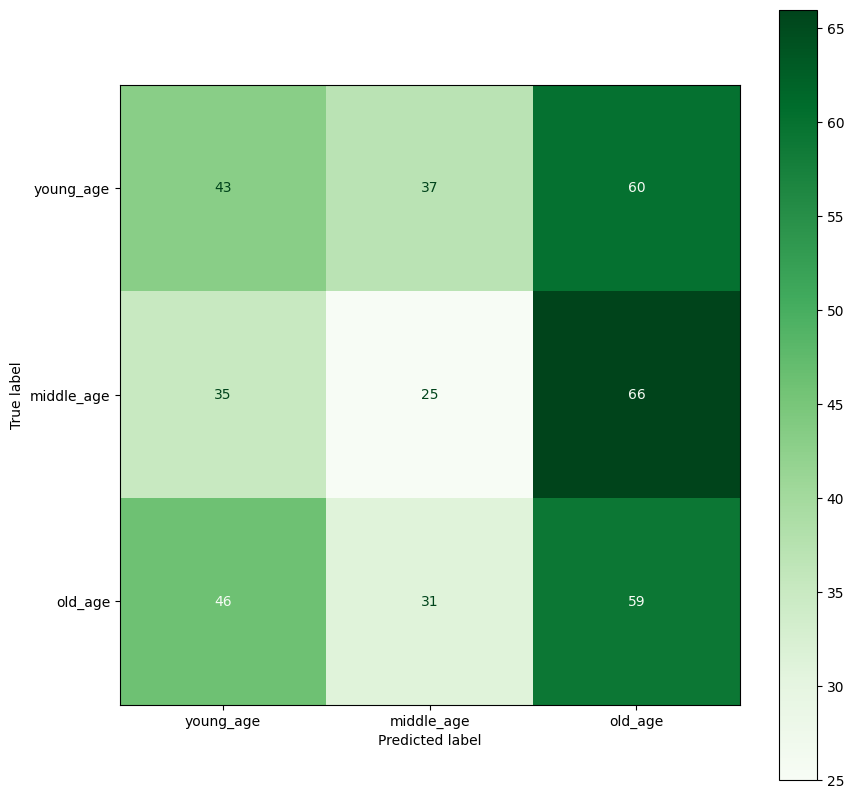

In [73]:
# Creating a confusion matrix to see how will the model predicts for each class

# Using the trained model to predict on the test data
predict_probs_cnn_base = model_base.predict(base_test_generator)

# Finding the class with the highest probability and storing its index as a predicted label
predict_labels_cnn_base = np.argmax(predict_probs_cnn_base, axis=1)

# Getting the true labels from the test generator
true_labels_cnn_base = base_test_generator.classes

# Calculating the confusion matrix for the predicted and true labels
cm_cnn_base = confusion_matrix(true_labels_cnn_base, predict_labels_cnn_base)

# Plotting the confusion matrix with the predicted and true labels
# Changing the color of the confusion matrix to green
disp_cnn_base = ConfusionMatrixDisplay(confusion_matrix=cm_cnn_base, display_labels=base_test_generator.class_indices.keys())
fig, ax = plt.subplots(figsize=(10,10))
disp_cnn_base.plot(cmap=plt.cm.Greens, ax=ax);

In [74]:
# Getting the labels from the test generator
class_names_cnn_base = list(base_test_generator.class_indices.keys())

# Creating a classification report to get the precision, recall, and f1-score
class_report_cnn_base = classification_report(true_labels_cnn_base, predict_labels_cnn_base, target_names=class_names_cnn_base)
print(class_report_cnn_base)

              precision    recall  f1-score   support

   young_age       0.35      0.31      0.33       140
  middle_age       0.27      0.20      0.23       126
     old_age       0.32      0.43      0.37       136

    accuracy                           0.32       402
   macro avg       0.31      0.31      0.31       402
weighted avg       0.31      0.32      0.31       402



### CNN Model

* The base model seemed to be overfit so I thought I can fix that with regularization and dropout
* I thought I can add new learning rate and amount of patience to reduce noise and see if the accuracy increases

In [75]:
# Creating a sequential model
model1 = models.Sequential()

# Adding a convolutional layer with 32 nodes, kernel size of 3x3, relu activation function, and input shape of 256x256 pixels with colored images
model1.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                        input_shape=(256, 256, 3)))

# Adding a max pooling layer with a pool size of 2x2 to reduce dimensionality
model1.add(layers.MaxPooling2D((2, 2)))

# Adding a flattening layer to convert 2D output of previous layer into a 1D vector
model1.add(layers.Flatten())

# Adding dense layers with 128 and 64 nodes respectively with a l2 regurlaization of 0.001 and dropout layers to reduce overfitting 
model1.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model1.add(layers.Dropout(0.25))

# Adding the last dense layer with 3 units which corresponds to 3 classes and softmax activation since this is a mullticlass classification
model1.add(layers.Dense(3, activation='softmax'))

# Configuring the model for training by specifying the loss function for a multiclass classification, the optimizer Adadelta to reduce noise, and evaluating accuracy
model1.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adadelta(learning_rate=1e-4),
              metrics=['accuracy'])

# Getting the summary of the model
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 516128)            0         
                                                                 
 dense_8 (Dense)             (None, 128)               66064512  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                      

In [76]:
# Creating an early stop if the model does not change in the validation accuracy by 0.001 for 7 epochs
early_stop_norm = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=7, mode='min')
# Fitting the model with 50 epochs and 45 steps per epoch
history_first = model1.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    callbacks=[early_stop_norm])

Epoch 1/50
45/45 [==============================] - 674s 15s/step - loss: 1.4559 - accuracy: 0.3482 - val_loss: 1.4353 - val_accuracy: 0.3874
Epoch 2/50
45/45 [==============================] - 58s 1s/step - loss: 1.4482 - accuracy: 0.3524 - val_loss: 1.4308 - val_accuracy: 0.4106
Epoch 3/50
45/45 [==============================] - 58s 1s/step - loss: 1.4427 - accuracy: 0.3496 - val_loss: 1.4295 - val_accuracy: 0.4007
Epoch 4/50
45/45 [==============================] - 58s 1s/step - loss: 1.4353 - accuracy: 0.3745 - val_loss: 1.4286 - val_accuracy: 0.4371
Epoch 5/50
45/45 [==============================] - 55s 1s/step - loss: 1.4307 - accuracy: 0.3784 - val_loss: 1.4255 - val_accuracy: 0.4305
Epoch 6/50
45/45 [==============================] - 57s 1s/step - loss: 1.4325 - accuracy: 0.3833 - val_loss: 1.4250 - val_accuracy: 0.4172
Epoch 7/50
45/45 [==============================] - 57s 1s/step - loss: 1.4319 - accuracy: 0.3917 - val_loss: 1.4242 - val_accuracy: 0.4007
Epoch 8/50
45/45 [

In [77]:
# Evaluating the model on the test data
test_results_1 = model1.evaluate(test_images, test_labels)

2/2 [==============================] - 0s 21ms/step - loss: 1.3259 - accuracy: 0.9688


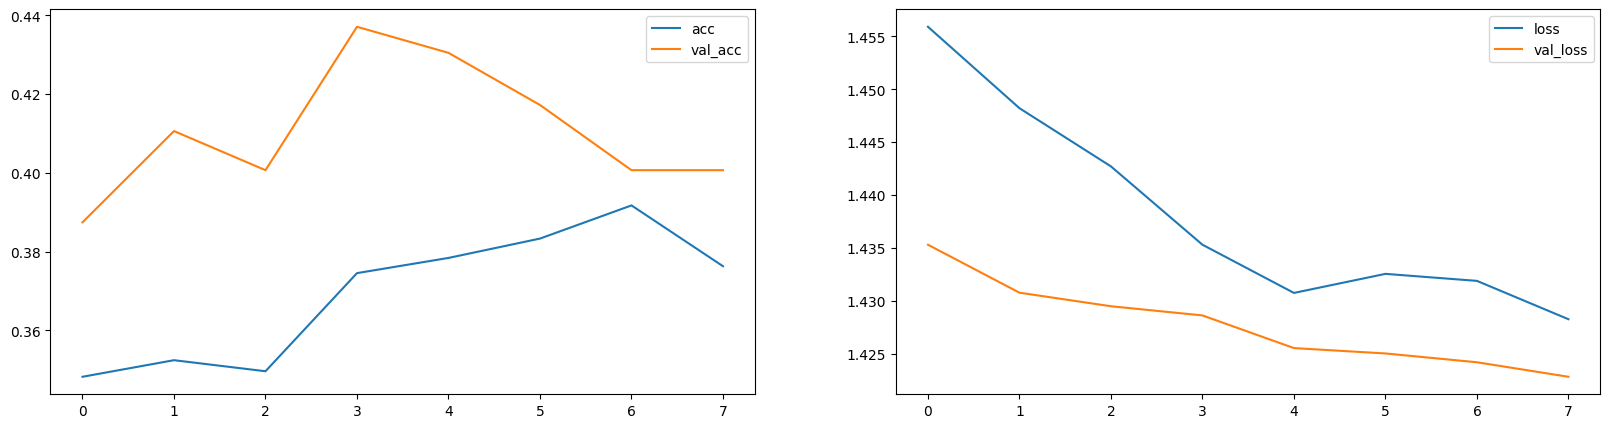

In [78]:
# Creating ROC Curve for the accuracy and the loss
acc_1 = history_first.history['accuracy']
val_acc_1 = history_first.history['val_accuracy']
loss_1 = history_first.history['loss']
val_loss_1 = history_first.history['val_loss']

# Plotting the training and validation accuracy on the first subplot
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.plot(acc_1, label='acc')
plt.plot(val_acc_1, label='val_acc')
plt.legend()

# Plotting the training and validation loss on the second subplot
plt.subplot(1, 2, 2)
plt.plot(loss_1, label= 'loss')
plt.plot(val_loss_1, label= 'val_loss')
plt.legend();

5/5 [==============================] - 10s 2s/step


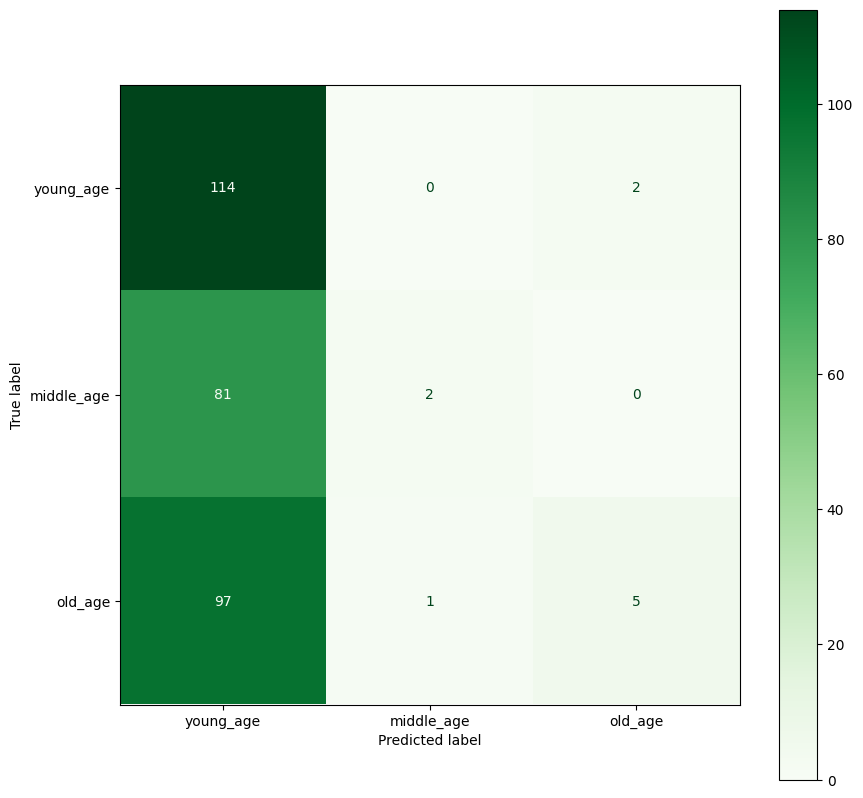

In [79]:
# Creating a confusion matrix to see how will the model predicts for each class

# Using the trained model to predict on the test data
predict_probs_cnn_1 = model1.predict(test_generator)

# Finding the class with the highest probability and storing its index as a predicted label
predict_labels_cnn_1 = np.argmax(predict_probs_cnn_1, axis=1)

# Getting the true labels from the test generator
true_labels_cnn_1 = test_generator.classes

# Calculating the confusion matrix for the predicted and true labels
cm_cnn_1 = confusion_matrix(true_labels_cnn_1, predict_labels_cnn_1)

# Plotting the confusion matrix with the predicted and true labels
# Changing the color of the confusion matrix to green
disp_cnn_1 = ConfusionMatrixDisplay(confusion_matrix=cm_cnn_1, display_labels=test_generator.class_indices.keys())
fig, ax = plt.subplots(figsize=(10,10))
disp_cnn_1.plot(cmap=plt.cm.Greens, ax=ax);

In [80]:
# Getting the labels from the test generator
class_names_cnn_1 = list(test_generator.class_indices.keys())

# Creating a classification report to get the precision, recall, and f1-score
class_report_cnn_1 = classification_report(true_labels_cnn_1, predict_labels_cnn_1, target_names=class_names_cnn_1)
print(class_report_cnn_1)

              precision    recall  f1-score   support

   young_age       0.39      0.98      0.56       116
  middle_age       0.67      0.02      0.05        83
     old_age       0.71      0.05      0.09       103

    accuracy                           0.40       302
   macro avg       0.59      0.35      0.23       302
weighted avg       0.58      0.40      0.26       302



### VGG19 and ResNet50 Models

* The regularization and dropout are not fixing the overfitting, but there is the preprocessing for vgg19 and resnet50 which can probably increase the accuracy
* The convolutional layer seems to not improve the accuracy score so I am going to lower the convolutional layer and add more dense layers



In [81]:
# Initialize a VGG19 base model with an input shape of 256x256 pixels with colored images and not including the top because the model is using transfer learning
vgg19_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(256, 256, 3))

# Defining model architecture
model2 = models.Sequential()

# Adding the vgg19 to the model
model2.add(vgg19_base)

# Adding a convolutional layer with 64 nodes, kernel size of 3x3, and relu activation function
model2.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))

# Adding a flattening layer to convert 2D output of previous layer into a 1D vector
model2.add(layers.Flatten())

# Adding dense layers with 64, 128, 256, and 128 nodes respectively with a l2 regurlaization of 0.001 and dropout layers to reduce overfitting 
model2.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model2.add(layers.Dropout(0.25))
model2.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model2.add(layers.Dropout(0.25))
model2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model2.add(layers.Dropout(0.5))

# Adding the last dense layer with 3 units which corresponds to 3 classes, softmax activation since this is a mullticlass classification, and regularization of 0.001 to reduce overfitting
model2.add(layers.Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))

# Configuring the model for training by specifying the loss function for a multiclass classification, the optimizer RMSprop to optimize the learning rate based on weights, and evaluating accuracy
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Getting the summary of the model
model2.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 conv2d_13 (Conv2D)          (None, 6, 6, 64)          294976    
                                                                 
 flatten_5 (Flatten)         (None, 2304)              0         
                                                                 
 dense_11 (Dense)            (None, 64)                147520    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 128)               8320      
                                                       

In [82]:
# Creating an early stop if the model does not change in the validation accuracy by 0.001 for 8 epochs
early_stop = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=8)
# Fitting the model with 50 epochs and 45 steps per epoch
history1 = model2.fit(vgg19_train_generator,
                    steps_per_epoch=len(vgg19_train_generator),
                    epochs=50,
                    validation_data=vgg19_validation_generator,
                    validation_steps=len(vgg19_validation_generator),
                    callbacks=[early_stop])

Epoch 1/50
45/45 [==============================] - 112s 2s/step - loss: 1.6553 - acc: 0.3412 - val_loss: 1.6244 - val_acc: 0.3411
Epoch 2/50
45/45 [==============================] - 57s 1s/step - loss: 1.6233 - acc: 0.3436 - val_loss: 1.6025 - val_acc: 0.3841
Epoch 3/50
45/45 [==============================] - 57s 1s/step - loss: 1.6208 - acc: 0.3647 - val_loss: 1.5767 - val_acc: 0.3841
Epoch 4/50
45/45 [==============================] - 57s 1s/step - loss: 1.5624 - acc: 0.3752 - val_loss: 1.5295 - val_acc: 0.3841
Epoch 5/50
45/45 [==============================] - 57s 1s/step - loss: 1.5424 - acc: 0.3717 - val_loss: 1.5330 - val_acc: 0.3841
Epoch 6/50
45/45 [==============================] - 56s 1s/step - loss: 1.5065 - acc: 0.3629 - val_loss: 1.4549 - val_acc: 0.3841
Epoch 7/50
45/45 [==============================] - 56s 1s/step - loss: 1.4781 - acc: 0.3514 - val_loss: 1.5035 - val_acc: 0.3841
Epoch 8/50
45/45 [==============================] - 57s 1s/step - loss: 1.4576 - acc: 0.4

In [83]:
# Evaluating the model on the test data
test_results2 = model2.evaluate(vgg19_test_images, vgg19_test_labels)

2/2 [==============================] - 5s 206ms/step - loss: 1.3937 - acc: 0.6250


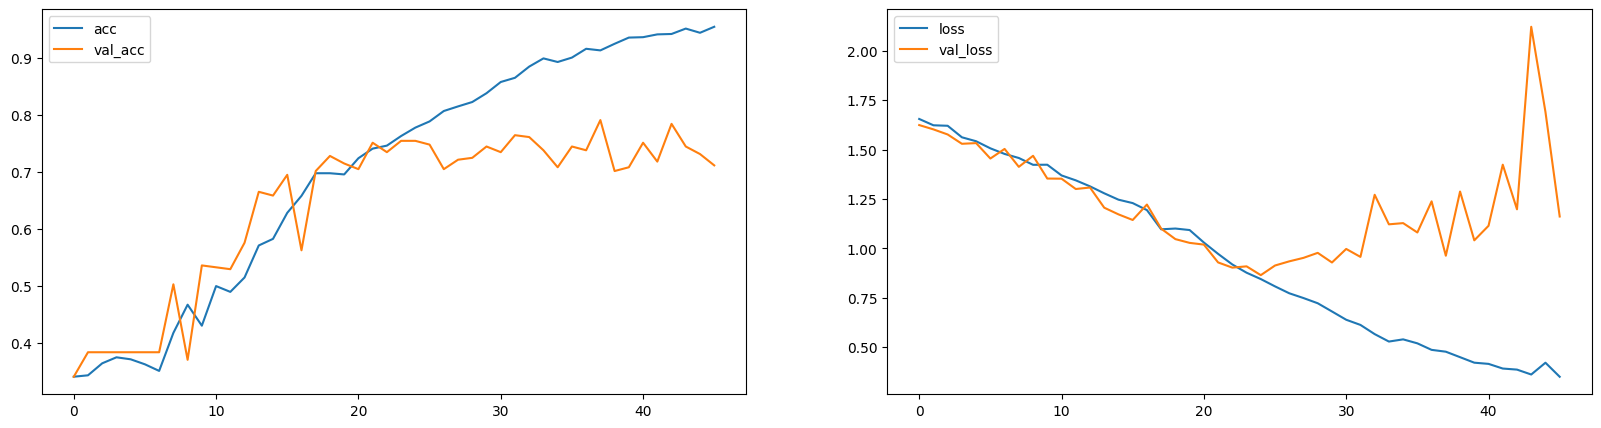

In [84]:
# Creating ROC Curve for the accuracy and the loss
acc_2 = history1.history['acc']
val_acc_2 = history1.history['val_acc']
loss_2 = history1.history['loss']
val_loss_2 = history1.history['val_loss']

# Plotting the training and validation accuracy on the first subplot
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.plot(acc_2, label='acc')
plt.plot(val_acc_2, label='val_acc')
plt.legend()

# Plotting the training and validation loss on the second subplot
plt.subplot(1, 2, 2)
plt.plot(loss_2, label= 'loss')
plt.plot(val_loss_2, label= 'val_loss')
plt.legend();

5/5 [==============================] - 2s 389ms/step


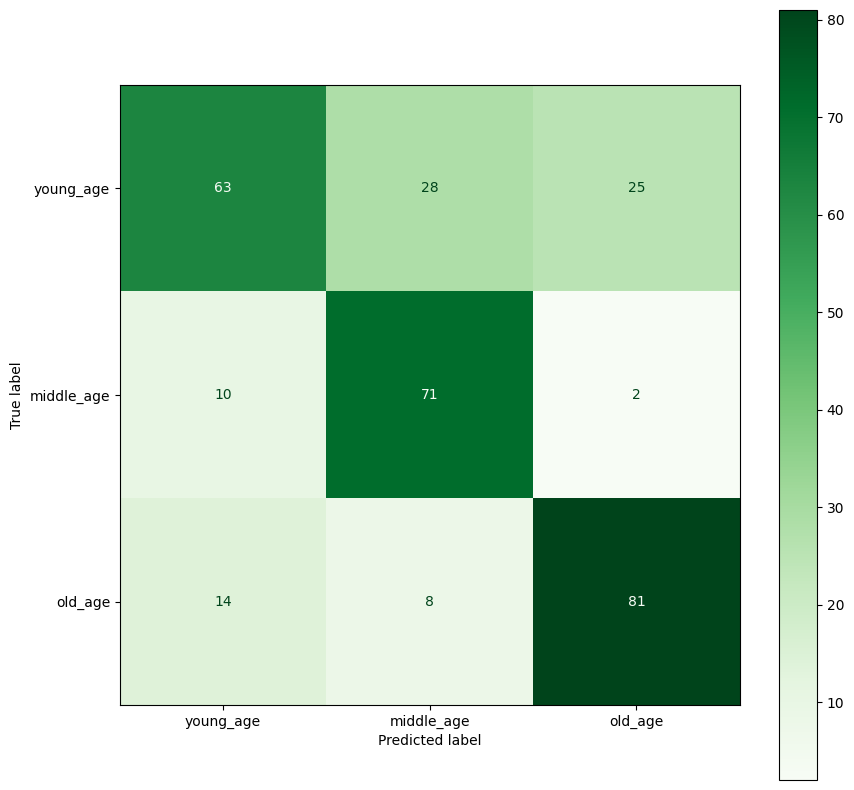

In [85]:
# Creating a confusion matrix to see how will the model predicts for each class

# Using the trained model to predict on the test data
predict_probs_v_2 = model2.predict(vgg19_test_generator)

# Finding the class with the highest probability and storing its index as a predicted label
predict_labels_v_2 = np.argmax(predict_probs_v_2, axis=1)

# Getting the true labels from the vgg19 test generator
true_labels_v_2 = vgg19_test_generator.classes

# Calculating the confusion matrix for the predicted and true labels
cm_v_2 = confusion_matrix(true_labels_v_2, predict_labels_v_2)

# Plotting the confusion matrix with the predicted and true labels
# Changing the color of the confusion matrix to green
disp_v_2 = ConfusionMatrixDisplay(confusion_matrix=cm_v_2, display_labels=vgg19_test_generator.class_indices.keys())
fig, ax = plt.subplots(figsize=(10,10))
disp_v_2.plot(cmap=plt.cm.Greens, ax=ax);

In [86]:
# Getting the labels from the vgg19 test generator
class_names_v_2 = list(vgg19_test_generator.class_indices.keys())

# Creating a classification report to get the precision, recall, and f1-score
class_report_v_2 = classification_report(true_labels_v_2, predict_labels_v_2, target_names=class_names_v_2)
print(class_report_v_2)

              precision    recall  f1-score   support

   young_age       0.72      0.54      0.62       116
  middle_age       0.66      0.86      0.75        83
     old_age       0.75      0.79      0.77       103

    accuracy                           0.71       302
   macro avg       0.71      0.73      0.71       302
weighted avg       0.72      0.71      0.71       302



* The accuracy did improve dramatically, but there is still overfitting which is not good
* Now I want to try using resnet50 because I heard it generally gives a better accuracy score

In [87]:
# Initialize a resnet50 model with an input shape of 256x256 pixels with colored images and not including the top because the model is using transfer learning
resnet = ResNet50(weights='imagenet', include_top = False, input_shape=(256, 256, 3))

# Since the vgg19 and resnet50 are pretrained there is no point in making the layers trainable which is why it is set to false
for layer in resnet.layers:
  layer.trainable = False

# Adding a flattening layer to convert 2D output into a 1D vector
x = Flatten()(resnet.output)

# Adding dense layers with 256 and 128 nodes respectively with a l2 regurlaization of 0.001 to reduce overfitting 
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)

# Adding the last dense layer as the output with 3 units which corresponds to 3 classes, softmax activation since this is a mullticlass classification, and regularization of 0.001 to reduce overfitting
output = Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(x)

# Adding the resnet50 input and the dense layer as a model
model = Model(inputs=resnet.input, outputs=output)

# Configuring the model for training by specifying the loss function for a multiclass classification, the optimizer adam, and evaluating accuracy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Getting the summary of the model
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [88]:
# Creating an early stop if the model does not change in the validation accuracy by 0.001 for 8 epochs
early_stop_res = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=8)

# Fitting the model with 50 epochs and 45 steps per epoch
history_res = model.fit(resnet50_train_generator,
                        steps_per_epoch=len(resnet50_train_generator), 
                        epochs=50, 
                        validation_data=resnet50_validation_generator, 
                        validation_steps=len(resnet50_validation_generator),
                        callbacks=[early_stop_res])

Epoch 1/50
45/45 [==============================] - 27s 455ms/step - loss: 5.2692 - accuracy: 0.3654 - val_loss: 2.1112 - val_accuracy: 0.4139
Epoch 2/50
45/45 [==============================] - 17s 368ms/step - loss: 2.2044 - accuracy: 0.4012 - val_loss: 1.7403 - val_accuracy: 0.4305
Epoch 3/50
45/45 [==============================] - 17s 369ms/step - loss: 1.5962 - accuracy: 0.4314 - val_loss: 1.5236 - val_accuracy: 0.4470
Epoch 4/50
45/45 [==============================] - 17s 366ms/step - loss: 1.4188 - accuracy: 0.4500 - val_loss: 1.2456 - val_accuracy: 0.4834
Epoch 5/50
45/45 [==============================] - 17s 369ms/step - loss: 1.1409 - accuracy: 0.5090 - val_loss: 1.5042 - val_accuracy: 0.5232
Epoch 6/50
45/45 [==============================] - 16s 357ms/step - loss: 1.0844 - accuracy: 0.5479 - val_loss: 1.2054 - val_accuracy: 0.4437
Epoch 7/50
45/45 [==============================] - 17s 368ms/step - loss: 1.3172 - accuracy: 0.4637 - val_loss: 1.2610 - val_accuracy: 0.3841

In [89]:
# Evaluating the model on the test data
test_results_res = model.evaluate(resnet50_test_images, resnet50_test_labels)

2/2 [==============================] - 2s 130ms/step - loss: 0.9264 - accuracy: 0.6719


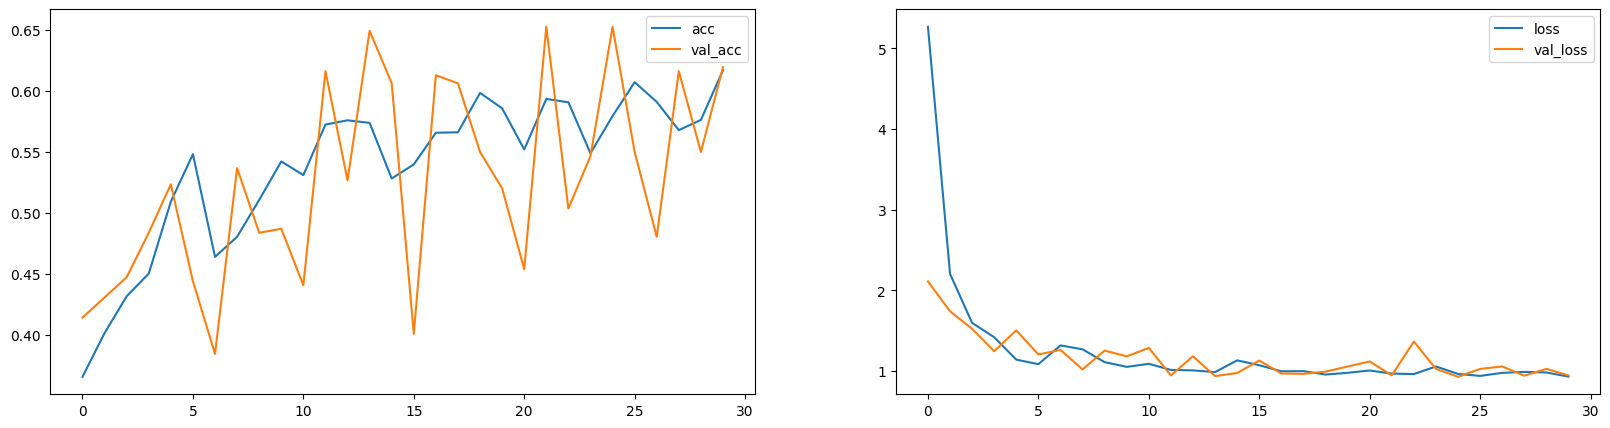

In [90]:
# Creating ROC Curve for the accuracy and the loss
acc_res = history_res.history['accuracy']
val_acc_res = history_res.history['val_accuracy']
loss_res = history_res.history['loss']
val_loss_res = history_res.history['val_loss']

# Plotting the training and validation accuracy on the first subplot
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.plot(acc_res, label='acc')
plt.plot(val_acc_res, label='val_acc')
plt.legend()

# Plotting the training and validation loss on the second subplot
plt.subplot(1, 2, 2)
plt.plot(loss_res, label= 'loss')
plt.plot(val_loss_res, label= 'val_loss')
plt.legend();

5/5 [==============================] - 2s 303ms/step


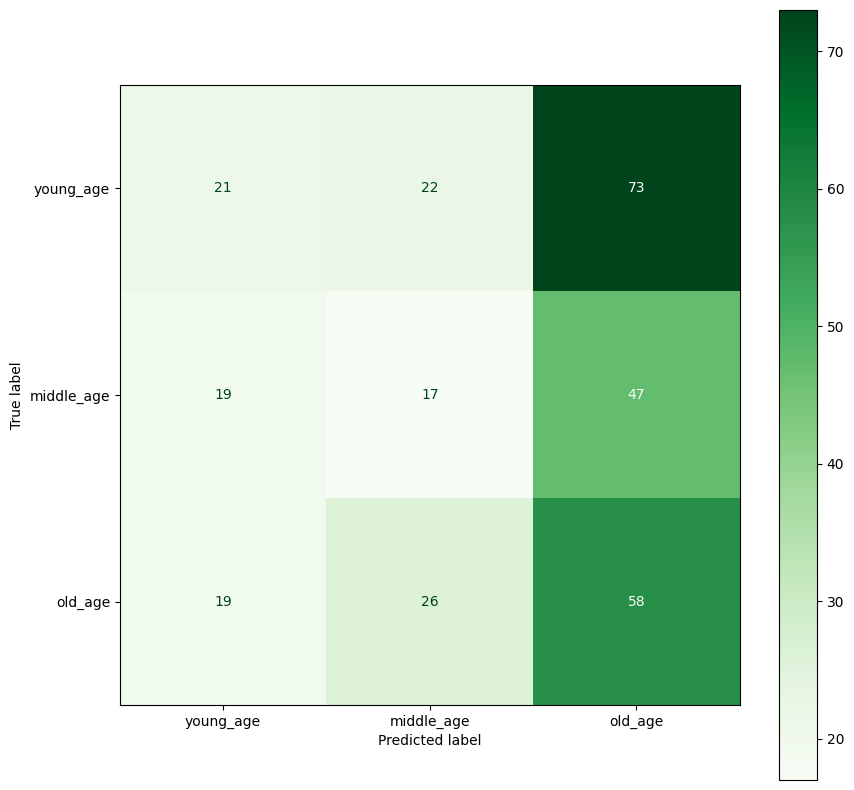

In [91]:
# Creating a confusion matrix to see how will the model predicts for each class

# Using the trained model to predict on the test data
predict_probs1 = model.predict(resnet50_test_generator)

# Finding the class with the highest probability and storing its index as a predicted label
predict_labels1 = np.argmax(predict_probs1, axis=1)

# Getting the true labels from the resnet50 test generator
true_labels1 = resnet50_test_generator.classes

# Calculating the confusion matrix for the predicted and true labels
cm1 = confusion_matrix(true_labels1, predict_labels1)

# Plotting the confusion matrix with the predicted and true labels
# Changing the color of the confusion matrix to green
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=resnet50_test_generator.class_indices.keys())
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Greens, ax=ax);

In [92]:
# Getting the labels from the resnet50 test generator
class_names1 = list(resnet50_test_generator.class_indices.keys())

# Creating a classification report to get the precision, recall, and f1-score
class_report1 = classification_report(true_labels1, predict_labels1, target_names=class_names1)
print(class_report1)

              precision    recall  f1-score   support

   young_age       0.36      0.18      0.24       116
  middle_age       0.26      0.20      0.23        83
     old_age       0.33      0.56      0.41       103

    accuracy                           0.32       302
   macro avg       0.31      0.32      0.29       302
weighted avg       0.32      0.32      0.30       302



## Best Model

* Making a complex neural network seems to do not as well, but if I tried making it simpler it might do better
* The vgg19 model did the best so far and I will just add a dense layer to make it as simple as possible
* Reduce LROn Plateau can help make the accuracy score better by reducing the learning rate which makes the convergence faster



In [93]:
# Initialize a vgg19 model with an input shape of 256x256 pixels with colored images and not including the top because the model is using transfer learning
vgg19_model_s = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Since the vgg19 and resnet50 are pretrained there is no point in making the layers trainable which is why it is set to false
for layer in vgg19_model_s.layers:
    layer.trainable = False

# Defining model architecture
s_model = Sequential()

# Adding the vgg19 to the neural network
s_model.add(vgg19_model_s)

# Adding a flattening layer to convert 2D output into a 1D vector
s_model.add(Flatten())

# Adding dense layers with 256 nodes with a l2 regurlaization of 0.001 and a dropout to reduce overfitting 
s_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
s_model.add(Dropout(0.5))

# Adding the last dense layer with 3 units which corresponds to 3 classes and softmax activation since this is a mullticlass classification
s_model.add(Dense(3, activation='softmax'))

# Configuring the model for training by specifying the loss function for a multiclass classification, the optimizer adam, and evaluating accuracy
s_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Getting the summary of the model
s_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_7 (Flatten)         (None, 32768)             0         
                                                                 
 dense_19 (Dense)            (None, 256)               8388864   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_20 (Dense)            (None, 3)                 771       
                                                                 
Total params: 28,414,019
Trainable params: 8,389,635
Non-trainable params: 20,024,384
_________________________________________________________________


In [94]:
# Creating an early stop if the model does not change in the validation accuracy by 0.001 for 8 epochs
early_stop_s = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=8)

# Reduucing the learning rate if the validation accuracy stops improving by 0.2 for 4 epochs 
reduce_s = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4)
# Fitting the model with 100 epochs and 45 steps per epoch
history_s = s_model.fit(vgg19_train_generator,
                    steps_per_epoch=len(vgg19_train_generator),
                    epochs=100,
                    validation_data=vgg19_validation_generator,
                    validation_steps=len(vgg19_validation_generator),
                    verbose=1,
                    callbacks=[early_stop_s, reduce_s])

Epoch 1/100
45/45 [==============================] - 22s 461ms/step - loss: 2.4339 - accuracy: 0.5349 - val_loss: 0.9918 - val_accuracy: 0.7185 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 21s 459ms/step - loss: 0.9997 - accuracy: 0.6557 - val_loss: 0.8707 - val_accuracy: 0.6854 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 20s 446ms/step - loss: 0.9139 - accuracy: 0.6757 - val_loss: 0.7862 - val_accuracy: 0.7285 - lr: 0.0010
Epoch 4/100
45/45 [==============================] - 20s 436ms/step - loss: 0.8596 - accuracy: 0.6974 - val_loss: 0.7469 - val_accuracy: 0.7781 - lr: 0.0010
Epoch 5/100
45/45 [==============================] - 20s 440ms/step - loss: 0.7801 - accuracy: 0.7325 - val_loss: 0.7283 - val_accuracy: 0.7285 - lr: 0.0010
Epoch 6/100
45/45 [==============================] - 20s 448ms/step - loss: 0.7717 - accuracy: 0.7206 - val_loss: 0.7021 - val_accuracy: 0.7682 - lr: 0.0010
Epoch 7/100
45/45 [==============================] - 20s 4

In [95]:
# Evaluating the model on the test data
test_results_s = s_model.evaluate(vgg19_test_images, vgg19_test_labels)

2/2 [==============================] - 0s 197ms/step - loss: 0.7053 - accuracy: 0.7344


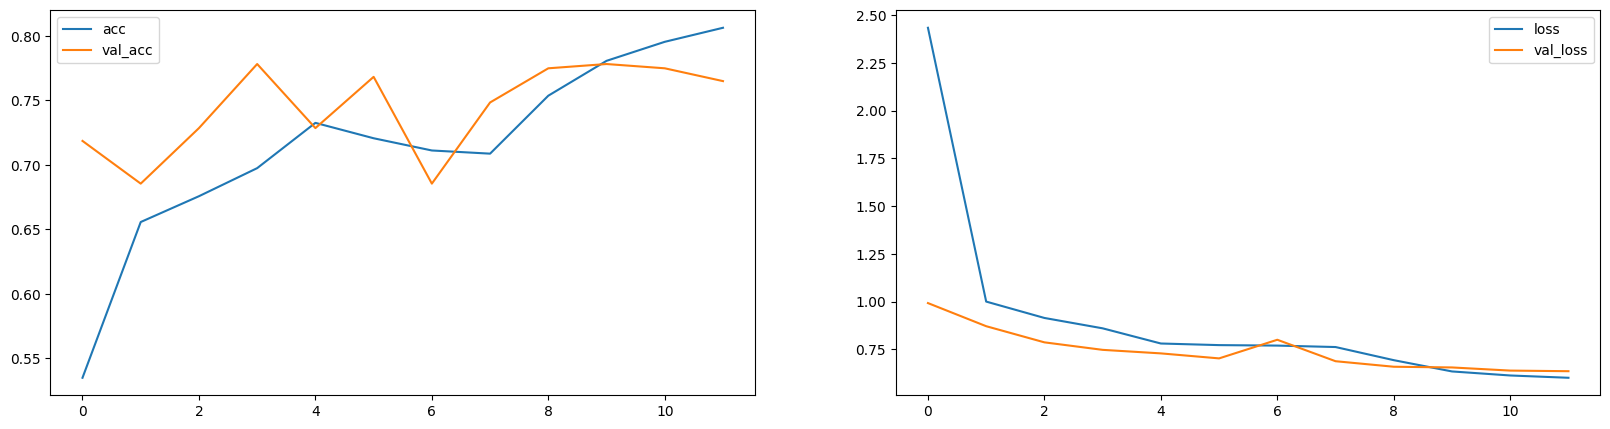

In [96]:
# Creating ROC Curve for the accuracy and the loss
acc_s = history_s.history['accuracy']
val_acc_s = history_s.history['val_accuracy']
loss_s = history_s.history['loss']
val_loss_s = history_s.history['val_loss']

# Plotting the training and validation accuracy on the first subplot
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.plot(acc_s, label='acc')
plt.plot(val_acc_s, label='val_acc')
plt.legend()

# Plotting the training and validation loss on the second subplot
plt.subplot(1, 2, 2)
plt.plot(loss_s, label= 'loss')
plt.plot(val_loss_s, label= 'val_loss')
plt.legend();

5/5 [==============================] - 2s 390ms/step


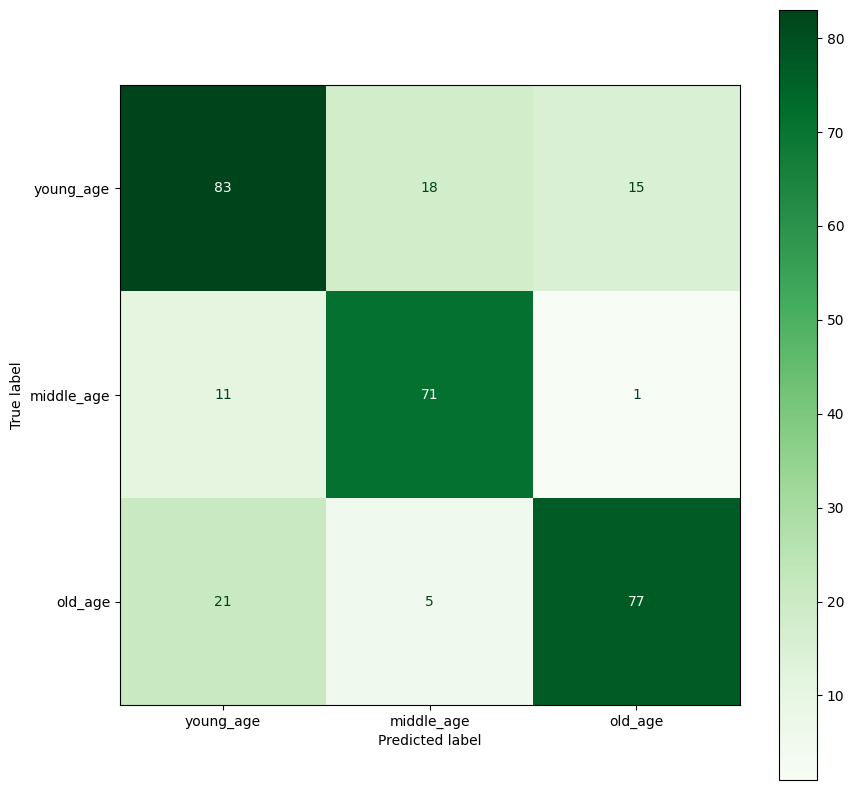

In [97]:
# Creating a confusion matrix to see how will the model predicts for each class

# Using the trained model to predict on the test data
predict_probs_s = s_model.predict(vgg19_test_generator)

# Finding the class with the highest probability and storing its index as a predicted label
predict_labels_s = np.argmax(predict_probs_s, axis=1)

# Getting the true labels from the resnet50 test generator
true_labels_s = vgg19_test_generator.classes

# Calculating the confusion matrix for the predicted and true labels
cm_s = confusion_matrix(true_labels_s, predict_labels_s)

# Plotting the confusion matrix with the predicted and true labels
# Changing the color of the confusion matrix to green
disp = ConfusionMatrixDisplay(confusion_matrix=cm_s, display_labels=vgg19_test_generator.class_indices.keys())
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Greens, ax=ax);

In [98]:
# Getting the labels from the vgg19 test generator
class_names_s = list(vgg19_test_generator.class_indices.keys())

# Creating a classification report to get the precision, recall, and f1-score
class_report_s = classification_report(true_labels_s, predict_labels_s, target_names=class_names_s)
print(class_report_s)

              precision    recall  f1-score   support

   young_age       0.72      0.72      0.72       116
  middle_age       0.76      0.86      0.80        83
     old_age       0.83      0.75      0.79       103

    accuracy                           0.76       302
   macro avg       0.77      0.77      0.77       302
weighted avg       0.77      0.76      0.76       302



In [ ]:
# Saving this model to my drive because it is the best one so far
s_model.save('/content/drive/MyDrive/Colab_Notebooks/vgg19_best_model_real.h5')

* The vgg19 model with one dense layer did the best so far
* Maybe if I try using the same layers for the resnet50 it might provide a better accuracy score because resnet50 has provided better results for other people



In [99]:
# Initialize a resnet50 model with an input shape of 256x256 pixels with colored images and not including the top because the model is using transfer learning
resnet_model_s = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Since the vgg19 and resnet50 are pretrained there is no point in making the layers trainable which is why it is set to false
for layer in resnet_model_s.layers:
    layer.trainable = False

# Defining model architecture
res1_model = Sequential()

# Adding the resnet50 to the neural network
res1_model.add(resnet_model_s)

# Adding a flattening layer to convert 2D output into a 1D vector
res1_model.add(Flatten())

# Adding dense layers with 256 nodes with a l2 regurlaization of 0.001 and a dropout to reduce overfitting 
res1_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
res1_model.add(Dropout(0.5))

# Adding the last dense layer with 3 units which corresponds to 3 classes and softmax activation since this is a mullticlass classification
res1_model.add(Dense(3, activation='softmax'))

# Configuring the model for training by specifying the loss function for a multiclass classification, the optimizer adam, and evaluating accuracy
res1_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Getting the summary of the model
res1_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_8 (Flatten)         (None, 131072)            0         
                                                                 
 dense_21 (Dense)            (None, 256)               33554688  
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 3)                 771       
                                                                 
Total params: 57,143,171
Trainable params: 33,555,459
Non-trainable params: 23,587,712
_________________________________________________________________


In [100]:
# Creating an early stop if the model does not change in the validation accuracy by 0.001 for 8 epochs
early_stop_res1 = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=8)

# Reducing the learning rate if the validation accuracy stops improving by 0.2 for 4 epochs 
reduce_res1 = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4)

# Fitting the model with 100 epochs and 45 steps per epoch
history_res1 = res1_model.fit(resnet50_train_generator,
                    steps_per_epoch=len(resnet50_train_generator),
                    epochs=100,
                    validation_data=resnet50_validation_generator,
                    validation_steps=len(resnet50_validation_generator),
                    verbose=1,
                    callbacks=[early_stop_res1, reduce_res1])

Epoch 1/100
45/45 [==============================] - 22s 409ms/step - loss: 6.7325 - accuracy: 0.3556 - val_loss: 1.1801 - val_accuracy: 0.3411 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 17s 368ms/step - loss: 1.1746 - accuracy: 0.3559 - val_loss: 1.1694 - val_accuracy: 0.3841 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 17s 370ms/step - loss: 1.1640 - accuracy: 0.3791 - val_loss: 1.1581 - val_accuracy: 0.3841 - lr: 0.0010
Epoch 4/100
45/45 [==============================] - 16s 344ms/step - loss: 1.1545 - accuracy: 0.3791 - val_loss: 1.1499 - val_accuracy: 0.3841 - lr: 0.0010
Epoch 5/100
45/45 [==============================] - 17s 368ms/step - loss: 1.1474 - accuracy: 0.3791 - val_loss: 1.1433 - val_accuracy: 0.3841 - lr: 0.0010
Epoch 6/100
45/45 [==============================] - 16s 349ms/step - loss: 1.1418 - accuracy: 0.3791 - val_loss: 1.1379 - val_accuracy: 0.3841 - lr: 0.0010
Epoch 7/100
45/45 [==============================] - 17s 3

In [101]:
# Evaluating the model on the test data
test_results_res1 = res1_model.evaluate(resnet50_test_images, resnet50_test_labels)

2/2 [==============================] - 0s 132ms/step - loss: 1.1269 - accuracy: 0.3906


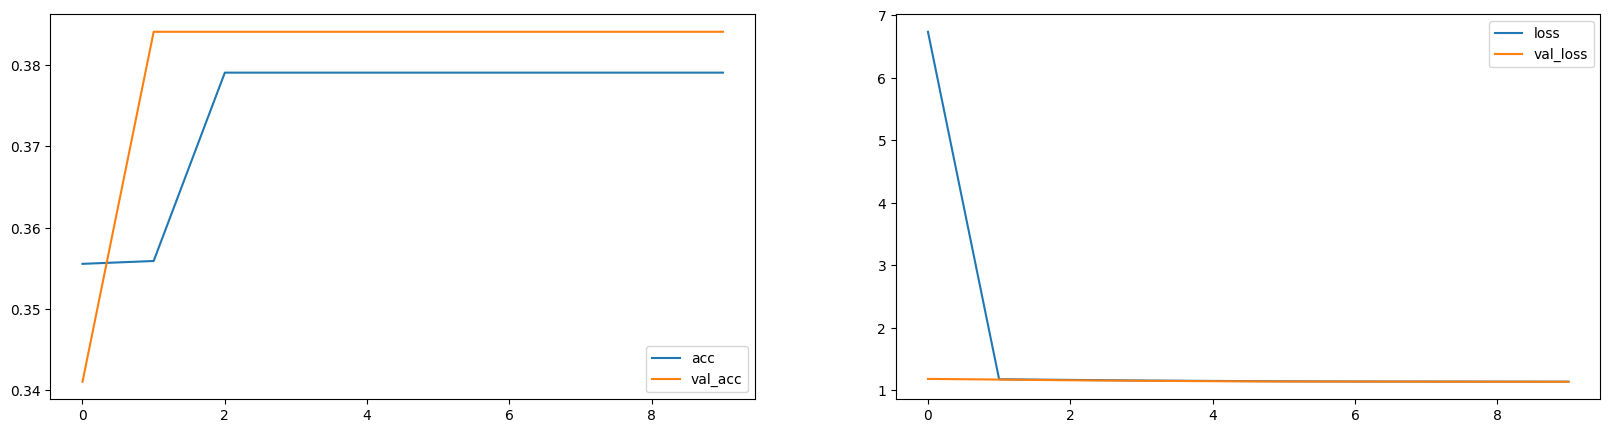

In [102]:
# Creating ROC Curve for the accuracy and the loss
acc_res1 = history_res1.history['accuracy']
val_acc_res1 = history_res1.history['val_accuracy']
loss_res1 = history_res1.history['loss']
val_loss_res1 = history_res1.history['val_loss']

# Plotting the training and validation accuracy on the first subplot
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.plot(acc_res1, label='acc')
plt.plot(val_acc_res1, label='val_acc')
plt.legend()

# Plotting the training and validation loss on the second subplot
plt.subplot(1, 2, 2)
plt.plot(loss_res1, label= 'loss')
plt.plot(val_loss_res1, label= 'val_loss')
plt.legend();

5/5 [==============================] - 2s 407ms/step


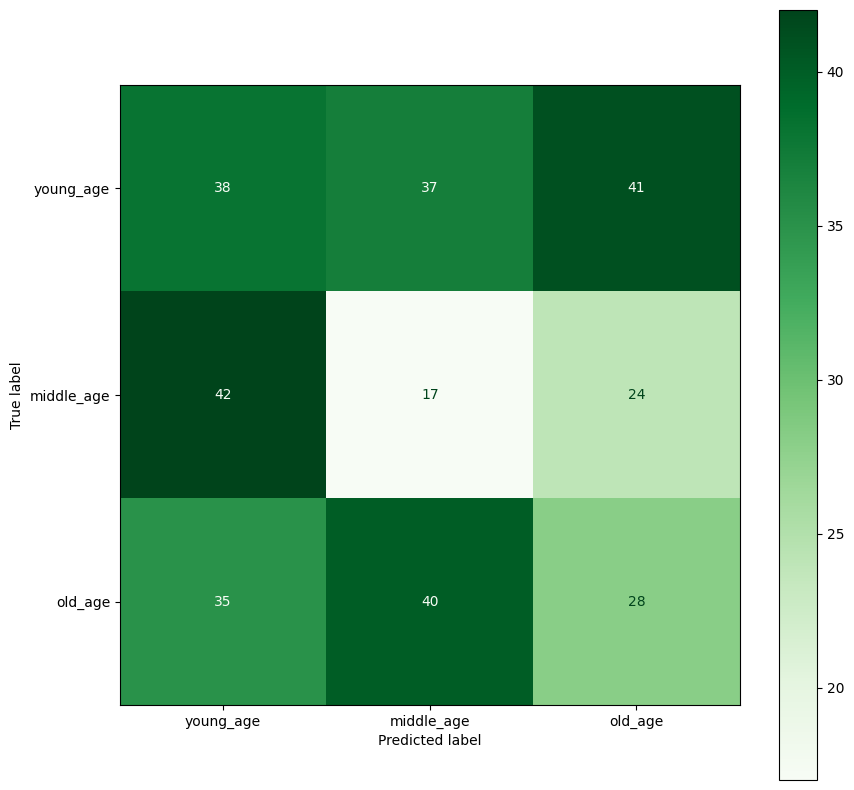

In [103]:
# Creating a confusion matrix to see how will the model predicts for each class

# Using the trained model to predict on the test data
predict_probs_s = s_model.predict(resnet50_test_generator)

# Finding the class with the highest probability and storing its index as a predicted label
predict_labels_s = np.argmax(predict_probs_s, axis=1)

# Getting the true labels from the resnet50 test generator
true_labels_s = resnet50_test_generator.classes

# Calculating the confusion matrix for the predicted and true labels
cm_s = confusion_matrix(true_labels_s, predict_labels_s)

# Plotting the confusion matrix with the predicted and true labels
# Changing the color of the confusion matrix to green
disp = ConfusionMatrixDisplay(confusion_matrix=cm_s, display_labels=resnet50_test_generator.class_indices.keys())
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Greens, ax=ax);

In [104]:
# Getting the labels from the resnet50 test generator
class_names_s = list(vgg19_test_generator.class_indices.keys())

# Creating a classification report to get the precision, recall, and f1-score
class_report_s = classification_report(true_labels_s, predict_labels_s, target_names=class_names_s)
print(class_report_s)

              precision    recall  f1-score   support

   young_age       0.33      0.33      0.33       116
  middle_age       0.18      0.20      0.19        83
     old_age       0.30      0.27      0.29       103

    accuracy                           0.27       302
   macro avg       0.27      0.27      0.27       302
weighted avg       0.28      0.27      0.28       302



# Evaluation



* My best model was the vgg19 model with one dense layer with 256 nodes with a l2 regularization(0.001) and dropout(0.5)
* Optimer adam, Early Stopping, and Reduce LROn Plateau 
* Resnet50 with the same layers, Early Stopping, and Reduce LROn Plateau did not provide a better accuracy score than the vgg19
* Score of 76% accuracy



# Recommendations


* Tik Tok can take this model and make it a part of the verification process where users can take a picture of themselves and verify if they actually are that old
* This model is not the best to use when the images are blurry because there are certain details that are left out



# Next Steps


* I want to try sharpening or make the images at a higher quality which can probably help improve my accuracy score
* I want to deploy this model to see how it fairs against new images
* I want to predict on 10 classes(which would be in the range of 10 years for each class) instead of 3 because I want to get more specific content and advertisements for each decade
* Lastly, I want to try improving the accuracy of the model which I can probably do by trying a vgg16 model or add more and new layers

